In [92]:
# This notebook exemplifies generating maps of hotspots and trends based on the gridded Daily Flood Index

In [50]:
from shapely.geometry import Polygon
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.ticker as ticker
plt.rcdefaults()
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

df = gpd.read_file(shpfilename)

def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]

def plot_map(interp_temps, title, label, lower_bound, upper_bound, vcenter, option, cmap_type, save, filename):
    # request data for use by geopandas
    resolution = '10m'
    category = 'cultural'
    name = 'admin_0_countries'
    data=interp_temps.copy()
    shpfilename = shapereader.natural_earth(resolution, category, name)
    df = geopandas.read_file(shpfilename)

    # get geometry of a country
    poly = [df.loc[df['ADMIN'] == 'Sweden']['geometry'].values[0]]

    stamen_terrain = cimgt.Stamen('terrain-background')
    # define the colormap
    if cmap_type=='SPI_cmap':
        cmap = colors.ListedColormap(['red', 'orange', 'yellow', 'white', 'lavender', 'plum', 'purple'])
        #define the boundaries of the SPI values for each color in the colormap
        #bounds = [-np.inf, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, np.inf]
        # create a norm object to map SPI values to colors
        #norm = colors.BoundaryNorm(bounds, cmap.N)
    elif cmap_type=='inverted':
        cmap='coolwarm_r' #'RdBu'
    else:
        cmap='coolwarm' #'RdBu_r'

    # projections that involved
    st_proj = ccrs.PlateCarree()  #projection used by Stamen images
    ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat

    # create fig and axes using intended projection
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1, projection=st_proj)
    ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')

    pad1 = .1  #padding, degrees unit
    exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
    ax.set_extent(exts, crs=ll_proj)

    # make a mask polygon by polygon's difference operation
    # base polygon is a rectangle, another polygon is simplified switzerland
    msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
    msk_stm  = st_proj.project_geometry (msk, ll_proj)  # project geometry to the projection used by stamen

    # get and plot Stamen images
    #ax.add_image(stamen_terrain, 8) # this requests image, and plot

    # plot the mask using semi-transparency (alpha=0.65) on the masked-out portion
    ax.add_geometries( msk_stm, st_proj, zorder=12, facecolor='white', edgecolor='k', alpha=1)

    #gl=ax.gridlines(draw_labels=True)
    #gl.xlabels_top = False
    #gl.ylabels_left = False
    

    if option=='imshow':
        data[data>upper_bound]=upper_bound
        data[data<lower_bound]=lower_bound
        if cmap_type=='SPI_cmap':
            bounds=[-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
            norm = colors.BoundaryNorm(bounds, cmap.N)
            im = ax.imshow(data, origin='lower', norm=norm,
                extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
                cmap=cmap, zorder=11)
        else:
            # Create bounds vector from 10th to 90th percentile with median in the center
            # Calculate the distance between center, lower and upper bounds
            lb=lower_bound
            ub=upper_bound
            dist = vcenter - lb
            dist2 = ub - vcenter
            # Create bounds vector from 10th to 90th percentile with median closer to p10
            bounds = [lb, lb + 0.25*dist , lb + 0.4*dist, lb + 0.5*dist, lb + 0.7*dist, lb + 0.8*dist, lb + 0.9*dist, lb + dist, vcenter + 0.25*dist2, vcenter + 0.5*dist2, vcenter + 0.75*dist2, vcenter + 0.8*dist2, vcenter + 0.9*dist2, ub]
            im = ax.imshow(data, origin='lower', #norm=BoundaryNorm(bounds, ncolors=256),
                vmin= lb, vmax=ub,
                extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
                cmap=cmap, zorder=11)
    else:
        if cmap_type=='SPI_cmap':
            bounds=[-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
        else:
            bounds= np.linspace(lower_bound, upper_bound, num=12)
        data[data>upper_bound]=upper_bound
        data[data<lower_bound]=lower_bound
        # Interpolate missing values
        data_interp = pd.DataFrame(data).interpolate(method='linear', axis=0).values
        im = ax.contourf(lon_grid, lat_grid, data_interp, levels=bounds,
            extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
            cmap=cmap, vmin=lower_bound, vmax=upper_bound, zorder=11)

    # add title
    plt.title(title, fontsize=18)
    # add a colorbar
    cbar_ax = fig.add_axes([0.188, -0.04, 0.623, 0.05]) # [left, bottom, width, height]
    num_ticks = 7  # Adjust this value as needed
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    tick_formatter = ticker.ScalarFormatter(useMathText=True)
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=1.2,
                        ticks=tick_locator, format=tick_formatter, extend='both')
    #plt.subplots_adjust(top=0.95, bottom=0.15, left=0.0, right=1, hspace=0.2, wspace=0.2)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, fontsize=14)
    if save=='yes':
        fig.savefig('figures/my_figure.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [2]:
# Read xarray of Flood indexes
import xarray as xr
fidx_ds = xr.open_dataset('Fidx.nc')


In [8]:
import numpy as np
lat_grid = np.linspace(55.3376, 69.1763, 100) 
lon_grid = np.linspace(11, 24.113, 100)

C:\Users\MarlonVieiraPassos\AppData\Local\Temp\ipykernel_6152\1307515053.py:2: RuntimeWarning: All-NaN slice encountered
  fidx_max = np.nanmax(fidx_ds['flood_index'].values, axis=0) # maximum flood index
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be rem

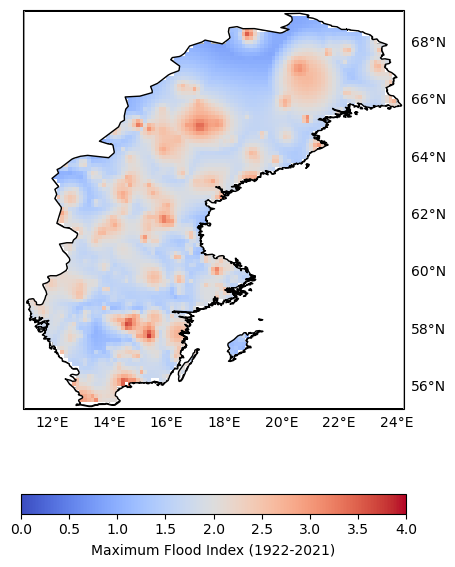

In [13]:
# Plot maximum flood index
fidx_max = np.nanmax(fidx_ds['flood_index'].values, axis=0) # maximum flood index
plot_map(fidx_max, 'Maximum Daily Flood Index (1922-2021)', 0, 4, 2, 'imshow', 'normal','no', 'no')

In [57]:
# convert time coordinate to datetime type
fidx_ds['time'] = pd.to_datetime(fidx_ds.time.values)

# set time coordinate as index
fidx_ds = fidx_ds.set_index(time='time')

In [39]:
# resample the pandas dataframe to monthly frequency and take the max value for each month
fidx_ds_mon = fidx_ds.resample(time='M').max()

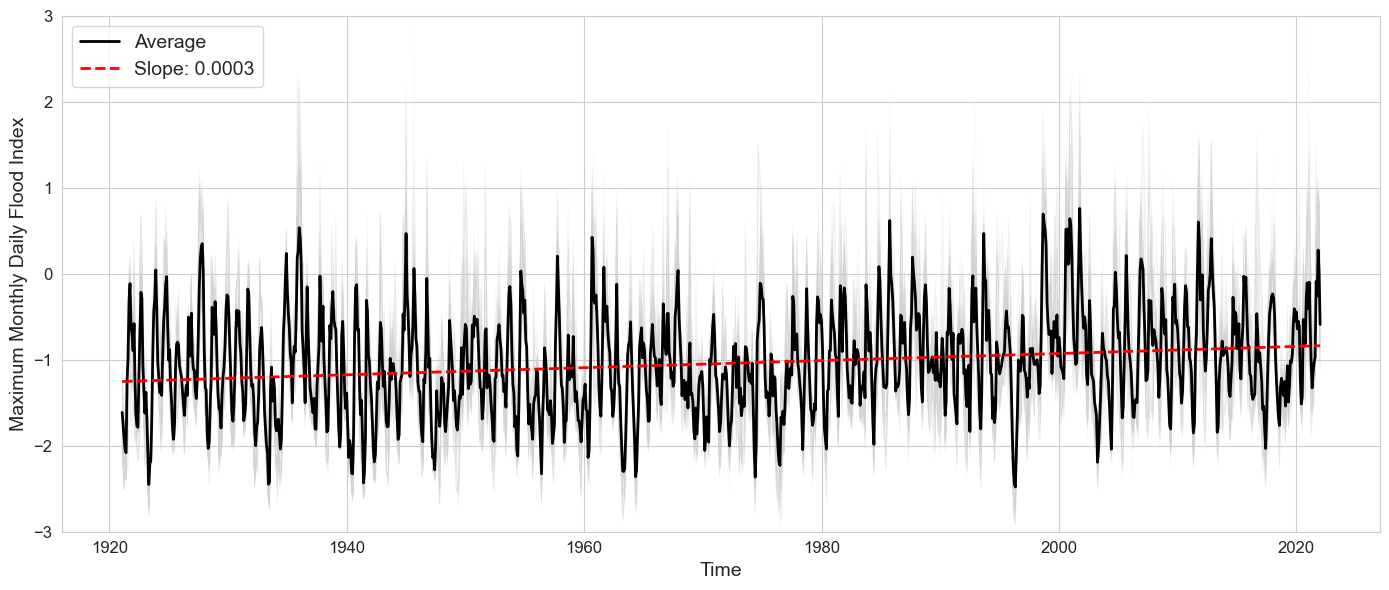

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import xarray as xr
# Plot Daily Flood Index
# convert dataset to dataframe
fidx_df = fidx_ds_mon.to_dataframe().reset_index()
# plot the data
plt.figure(figsize=(14,6))
sns.set_style('whitegrid')
for lat, lon in zip(fidx_df['lat'].unique(), fidx_df['lon'].unique()):
    fidx_df_subset = fidx_df[(fidx_df['lat'] == lat) & (fidx_df['lon'] == lon)]
    x = fidx_df_subset['time']
    y = fidx_df_subset['flood_index']
    plt.plot(x, y, color='lightgray', alpha=0.1, linewidth=0.5)    
avg_fidx_df = fidx_df.groupby('time').mean().reset_index()
slope, intercept, r_value, p_value, std_err = linregress(avg_fidx_df.index.values, avg_fidx_df['flood_index'])
trend_line = slope * avg_fidx_df.index.values + intercept
plt.plot(avg_fidx_df['time'], avg_fidx_df['flood_index'], color='black', linewidth=2, label='Average')
plt.plot(avg_fidx_df['time'], trend_line, color='red', linestyle='--', linewidth=2, label='Slope: '+str(round(slope,4)))
plt.ylim([-3, 3])

plt.xlabel('Time', fontsize=14)
plt.ylabel('Maximum Monthly Daily Flood Index', fontsize=14)
#plt.title('SPEI12 Timeseries', fontsize=14)
# Set the font size for tick labels
plt.tick_params(axis='both', labelsize=12)
#plt.legend(loc='upper center', ncol=10)
plt.legend(fontsize=14, loc='upper left')
plt.tight_layout()
plt.savefig('Fidx.svg')
plt.show()

In [44]:
# Top 3 years
avg_fidx_df.sort_values('flood_index')

,time,lat,lon,flood_index
903,1996-04-30,62.25695,17.5565,-2.478821
27,1923-04-30,62.25695,17.5565,-2.451106
902,1996-03-31,62.25695,17.5565,-2.448680
148,1933-05-31,62.25695,17.5565,-2.446552
244,1941-05-31,62.25695,17.5565,-2.432206
...,...,...,...,...
1088,2011-09-30,62.25695,17.5565,0.603359
776,1985-09-30,62.25695,17.5565,0.621352
958,2000-11-30,62.25695,17.5565,0.643772
931,1998-08-31,62.25695,17.5565,0.696402


In [55]:
def find_floods(time, idx_point):
    # initialize output arrays
    flood_days = np.zeros_like(idx_point)
    duration = np.zeros_like(idx_point)
    intensity = np.zeros_like(idx_point)
    frequency = np.zeros_like(idx_point)

    # find floods
    flood_start = -1
    num_floods = 0
    num_extreme_floods = 0 # new counter for extreme floods
    current_year = int(str(time[0].astype('M8[Y]')).split('-')[0])
    for i, (fidx, dt) in enumerate(zip(idx_point, time)):
        year = int(str(dt.astype('M8[Y]')).split('-')[0])
        if year > current_year:
            current_year = year
            num_floods = 0
            num_extreme_floods = 0 # reset counters at the start of each new year

        if fidx > 0:
            if flood_start == -1:
                flood_start = i
            flood_days[i] = 1
        else:
            if flood_start != -1:
                flood_end = i - 1
                flood_duration = flood_end - flood_start + 1
                duration[flood_start] = flood_duration
                flood_intensity = np.sum(idx_point[flood_start:flood_end+1])
                intensity[flood_start] = flood_intensity
                flood_peak = np.min(idx_point[flood_start:flood_end+1])
                if flood_peak>=0: # # count all floods
                    frequency[flood_start] = num_extreme_floods + 1 # increment the frequency counter
                    num_extreme_floods += 1 # increment the counter for extreme floods only
                num_floods += 1 # always increment the total flood counter
                flood_start = -1

    # handle last flood if it exists
    if flood_start != -1:
        flood_end = len(idx_point) - 1
        flood_duration = flood_end - flood_start + 1
        duration[flood_start] = flood_duration
        flood_intensity = np.sum(idx_point[flood_start:flood_end+1])
        intensity[flood_start] = flood_intensity
        flood_peak = np.min(idx_point[flood_start:flood_end+1])
        if flood_peak>=0: # count all floods
            frequency[flood_start] = num_extreme_floods + 1 # increment the frequency counter
            num_extreme_floods += 1 # increment the counter for extreme floods only

    return duration, intensity, flood_days, frequency

In [53]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [58]:
# Check flood information
lat_near= find_nearest(fidx_ds.lat.values, 68)
lon_near= find_nearest(fidx_ds.lon.values, 18.1)
time = fidx_ds.sel(lat=lat_near, lon=lon_near)['time'].values
fidx_values = fidx_ds.sel(lat=lat_near, lon=lon_near)['flood_index'].values
duration, intensity, flood_days, frequency = find_floods(time, fidx_values)
sample_df=pd.DataFrame(columns=['time','flood_index','duration','intensity','flood_days','frequency'])
sample_df['time']=time
sample_df['flood_index']=fidx_values
sample_df['duration']=duration
sample_df['intensity']=intensity
sample_df['flood_days']=flood_days
sample_df['frequency']=frequency
#sample_df.to_excel('Flood detection check.xlsx')

In [ ]:
# Detect flood duration, intensity and frequency
import xarray as xr
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Compute drought intensity, duration and frequency at all points and save results
fidx_ds = xr.open_dataset('fidx.nc')
# convert time coordinate to datetime type
fidx_ds['time'] = pd.to_datetime(fidx_ds.time.values)
# set time coordinate as index
fidx_ds = fidx_ds.set_index(time='time')

lat_grid = np.linspace(55.3376, 69.1763, 100) 
lon_grid = np.linspace(11, 24.113, 100)

# Create empty dataset with desired dimensions and coordinates
ds = xr.Dataset(
    {
        'fl_durs': (['time', 'lat', 'lon'], np.zeros((len(fidx_ds.time.values), 100, 100))),
        'fl_ints': (['time', 'lat', 'lon'], np.zeros((len(fidx_ds.time.values), 100, 100))),
        'fl_days': (['time', 'lat', 'lon'], np.zeros((len(fidx_ds.time.values), 100, 100))),
        'fl_freq': (['time', 'lat', 'lon'], np.zeros((len(fidx_ds.time.values), 100, 100))),
    },
    coords={
        'time': fidx_ds.time.values,
        'lat': lat_grid,
        'lon': lon_grid,
    }
)

# Fill in dataset with drought data
with tqdm(total=(len(lat_grid)*len(lon_grid))) as pbar:
    for i in range(len(lat_grid)):
        #print(i)
        for j in range(len(lon_grid)):
            #print(j)
            fidx_values = fidx_ds.flood_index.values[:, i, j] # timeseries at point i,j
            #print(np.nanmax(fidx_ds_values))
            duration, intensity, flood_days, frequency = find_floods(time, fidx_values)
            ds['fl_durs'][:,i,j] = duration
            ds['fl_ints'][:,i,j] = intensity
            ds['fl_days'][:,i,j] = flood_days
            ds['fl_freq'][:,i,j] = frequency
            pbar.update(1) 
# Save dataset as netCDF file
ds.to_netcdf('flood_data.nc')
ds.close()

In [5]:
import xarray as xr
import pandas as pd
import numpy as np

In [27]:
fl_ds = xr.open_dataset('flood_data.nc')
fl_ds_yearly =fl_ds.resample(time='1Y').sum('time') 
#fl_ds_decade =fl_ds_yearly.resample(time='10Y').sum('time')

In [45]:
dfi_ds = xr.open_dataset('Fidx.nc')

In [57]:
# Convert 'time' dtype to datetime64[ns]
dfi_ds['time'] = xr.DataArray(pd.to_datetime(dfi_ds.time.values))

# Verify the updated dtype
print(dfi_ds.time.dtype)

datetime64[ns]


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

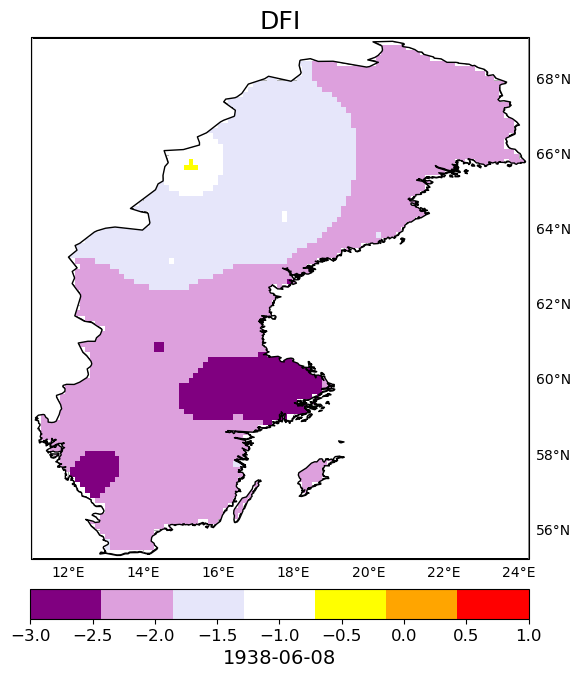

In [104]:
import numpy as np

# Specify the day, month and year of interest
target_day = 8
target_month = 6
target_year = 1938

# Convert target day, month, and year to numpy.datetime64 objects
target_date = np.datetime64(f'{target_year}-{target_month:02}-{target_day:02}')

fl_time = dfi_ds['time']
delta_time = np.abs((fl_time - target_date).astype('timedelta64[M]'))
t = delta_time.argmin()

# Extract day, month, and year from the selected time index
selected_time = dfi_ds.time.values[t]
day = np.datetime_as_string(selected_time, unit='D')
month = np.datetime_as_string(selected_time, unit='M')
year = np.datetime_as_string(selected_time, unit='Y')

# Call the plot_map function with the corrected time values
plot_map(dfi_ds['flood_index'].values[t,:], 'DFI', f'{day}', -3, 1, 0, 'imshow', 'DFI_cmap', 'no', 'noname')


In [28]:
fl_ds_yearly2 =fl_ds.resample(time='1Y').max('time') # for counting frequency of floods

In [29]:
# define a function to calculate percentiles along the time dimension
def calc_percentiles(data):
    return np.nanpercentile(data, [10, 50, 90], axis=0)
fl_durs_np = fl_ds_yearly.fl_durs.values 
#fl_durs_np[fl_durs_np==0]=np.nan 
fl_ints_np = fl_ds_yearly.fl_ints.values 
#fl_ints_np[fl_ints_np==0] = np.nan  # deactivated, including 0s now
#fl_freq_np = fl_ds_yearly.fl_days.values # number of days/pear under flood condition
fl_freq_np = fl_ds_yearly2.fl_freq.values # number of flood events
#fl_freq_np = np.nan_to_num(fl_freq_np, nan=0)
dur_perc_np = calc_percentiles(fl_durs_np)
int_perc_np = calc_percentiles(fl_ints_np)
freq_perc_np = calc_percentiles(fl_freq_np)



C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

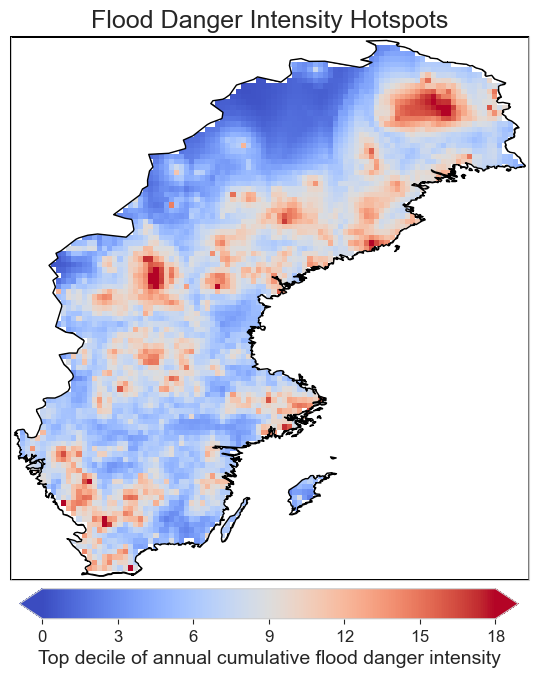

In [62]:
# Plot strongest intensities
#plot_data=np.nanmax(fl_ds.fl_ints.values, axis=0)
plot_data=int_perc_np[2]
lb=int(np.percentile(plot_data[plot_data>0], 0.01))
ub=int(np.percentile(plot_data[plot_data>0], 99.99))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
ub=18
#lb=10
#vcenter=0.5
#plot_map(plot_data, '90th Percentile Yearly Flood Intensity', lb, ub, vcenter, 'imshow', 'normal','no','no')
plot_map(plot_data, 'Flood Danger Intensity Hotspots', 'Top decile of annual cumulative flood danger intensity', lb, ub, vcenter, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

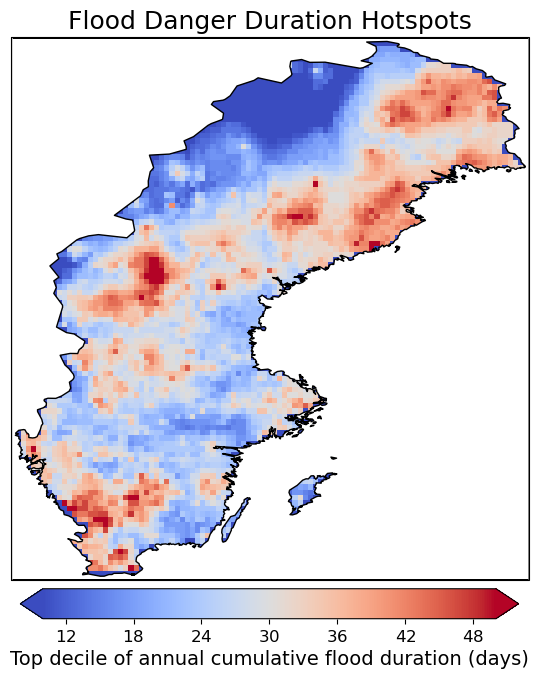

In [52]:
# Plot longest durations
#plot_data=np.nanmax(dr_durs_np, axis=0)/12
plot_data=dur_perc_np[2]#/12
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
ub=50
#lb=35
#vcenter=5
#plot_map(plot_data, '90th Percentile Yearly Flood Condition Duration (days)', lb, ub, vcenter, 'imshow', 'normal','no','no')
plot_map(plot_data, 'Flood Danger Duration Hotspots', 'Top decile of annual cumulative flood duration (days)', lb, ub, vcenter, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

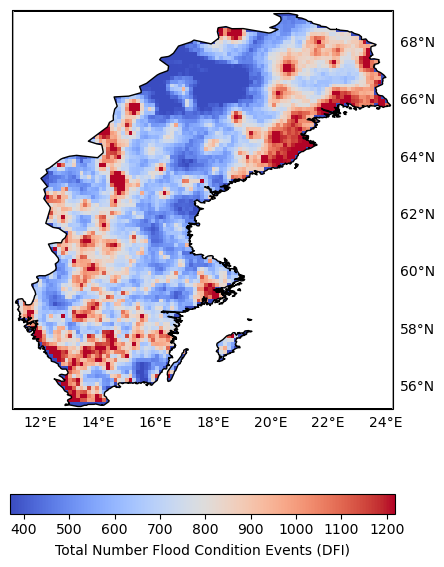

In [17]:
# Plot days under flood conditions
#plot_data=freq_perc_np[2] # 90th percentile of droughts per decade or year depending on previous cell
plot_data=np.nansum(fl_ds_yearly.fl_freq.values, axis=0)
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
#ub=100
#lb=70
#vcenter=2
plot_map(plot_data, 'Total Number Flood Condition Events (DFI)', lb, ub, vcenter, 'imshow', 'normal','no','no')


C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

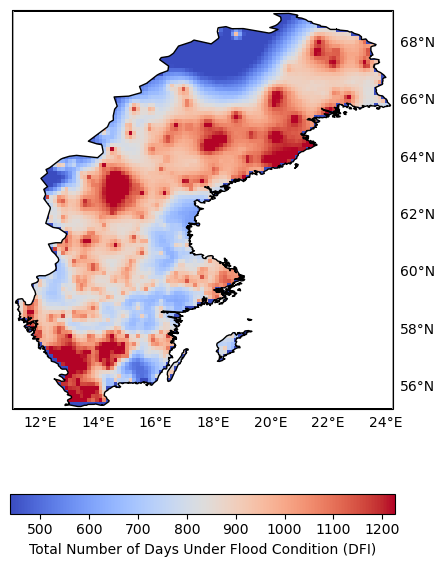

In [18]:
# Plot days under flood conditions
#plot_data=freq_perc_np[2] # 90th percentile of droughts per decade or year depending on previous cell
plot_data=np.nansum(fl_ds_yearly.fl_days.values, axis=0)
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
#ub=100
#lb=400
#vcenter=2
plot_map(plot_data, 'Total Number of Days Under Flood Condition (DFI)', lb, ub, vcenter, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

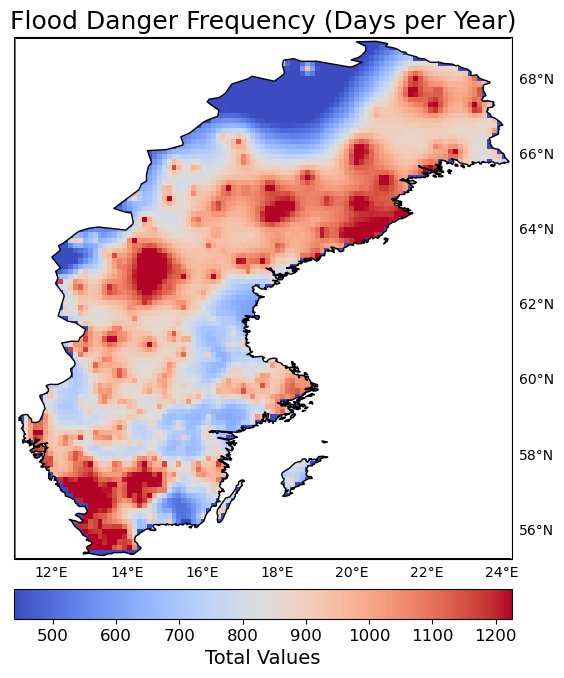

In [23]:
# Plot days under flood conditions
#plot_data=freq_perc_np[2] # 90th percentile of droughts per decade or year depending on previous cell
values=fl_ds_yearly.fl_days.values
#values[values==0]=np.nan # Consider non danger days or not
plot_data=np.nansum(values, axis=0)#/100
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
#ub=100
#lb=400
#vcenter=2
#plot_map(plot_data, 'Flood Condition Frequency (days/year)', lb, ub, vcenter, 'imshow', 'normal','no','no')
plot_map(plot_data, 'Flood Danger Frequency (Days per Year)', 'Total Values', lb, ub, vcenter, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

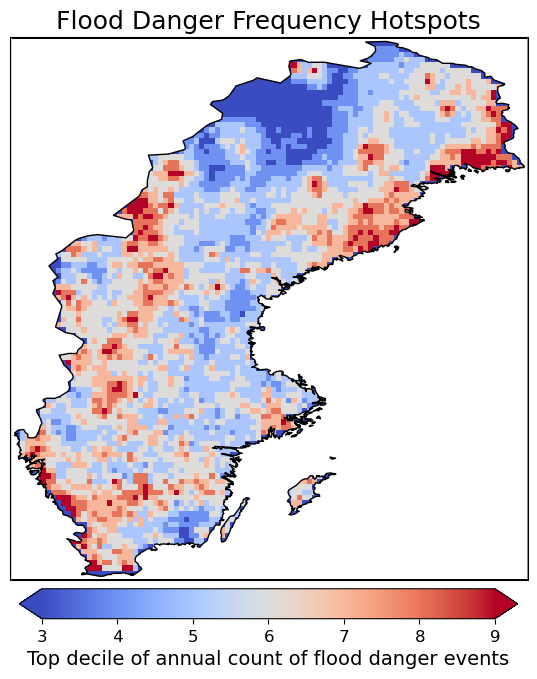

In [53]:
# Plot longest durations
plot_data=freq_perc_np[2]#/12
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
ub=9
plot_map(plot_data, 'Flood Danger Frequency Hotspots', 'Top decile of annual count of flood danger events', lb, ub, vcenter, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

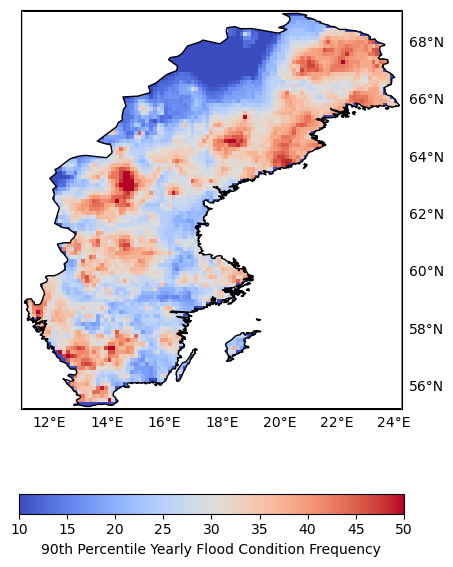

In [21]:
# Plot days under flood conditions
plot_data=freq_perc_np[2] # 90th percentile of droughts per decade or year depending on previous cell
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
ub=50
plot_map(plot_data, '90th Percentile Yearly Flood Condition Frequency', lb, ub, vcenter, 'imshow', 'normal','no','no')

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, linregress

def calculate_trends(data_array, alpha=0.05):
    timesteps, n_lat, n_lon = data_array.shape

    x = np.arange(timesteps)
    rate_of_change = np.empty((n_lat, n_lon))

    for i in range(n_lat):
        for j in range(n_lon):
            y = data_array[:, i, j]
            mask = ~np.isnan(y)
            if mask.sum() > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
                if p_value <= alpha:
                    rate_of_change[i, j] = slope
                else:
                    rate_of_change[i, j] = np.nan
            else:
                rate_of_change[i, j] = np.nan

    return rate_of_change

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

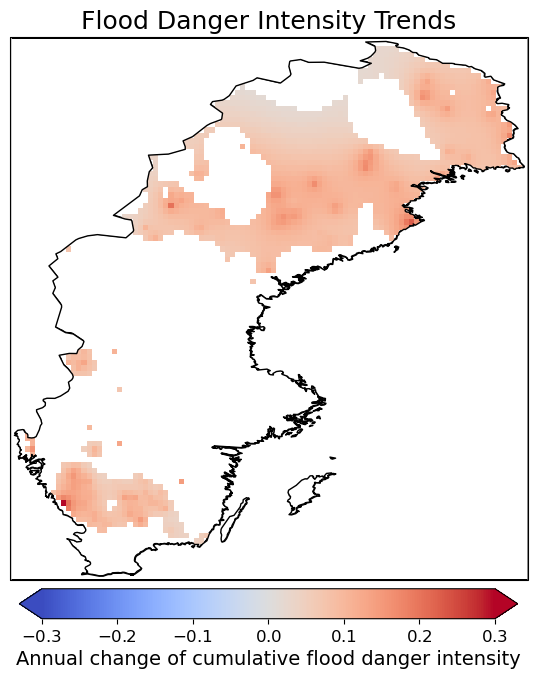

In [54]:
fl_dur_rate=calculate_trends(fl_ints_np) # Total duration per year
plot_map(fl_dur_rate, 'Flood Danger Intensity Trends', 'Annual change of cumulative flood danger intensity',-0.3, 0.3, 0, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

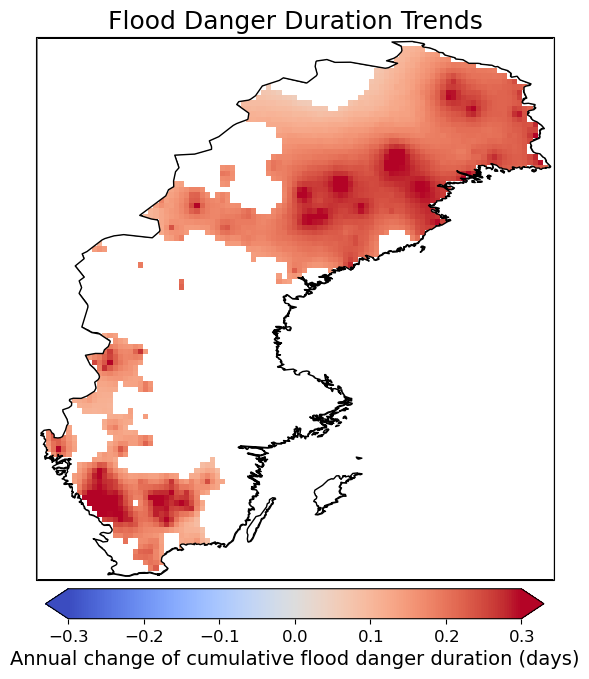

In [55]:
fl_dur_rate=calculate_trends(fl_durs_np) # Total duration per year, not considering zeroes
plot_map(fl_dur_rate, 'Flood Danger Duration Trends', 'Annual change of cumulative flood danger duration (days)',-0.3, 0.3, 0, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

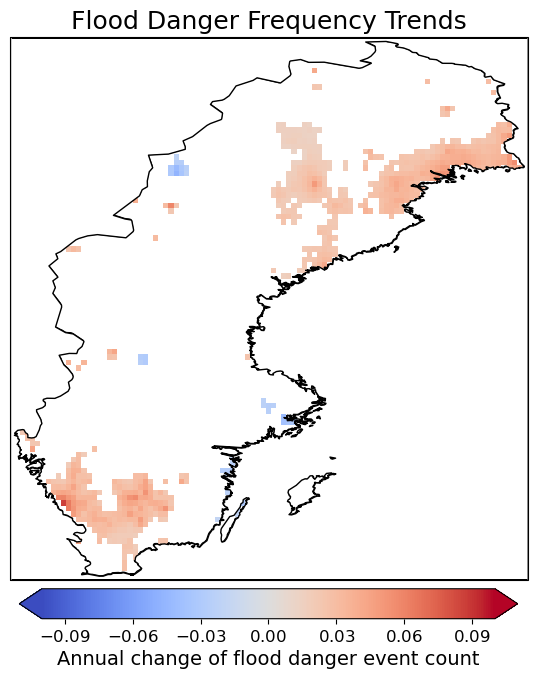

In [56]:
fl_freq_rate=calculate_trends(fl_freq_np) 
plot_map(fl_freq_rate, 'Flood Danger Frequency Trends','Annual change of flood danger event count', -0.1, 0.1, 0, 'imshow', 'normal','no','no')

In [69]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, linregress

def calculate_corr(data_array, data_array2):
    timesteps, n_lat, n_lon = data_array.shape
    corr = np.empty((n_lat, n_lon))
    for i in range(n_lat):
        for j in range(n_lon):
            x = data_array2[:, i, j]
            y = data_array[:, i, j]
            mask = ~np.isnan(y)
            if mask.sum() > 1 and np.unique(x).size != 1:
                slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
                corr[i, j] = r_value
            else:
                corr[i, j] = np.nan

    return corr

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

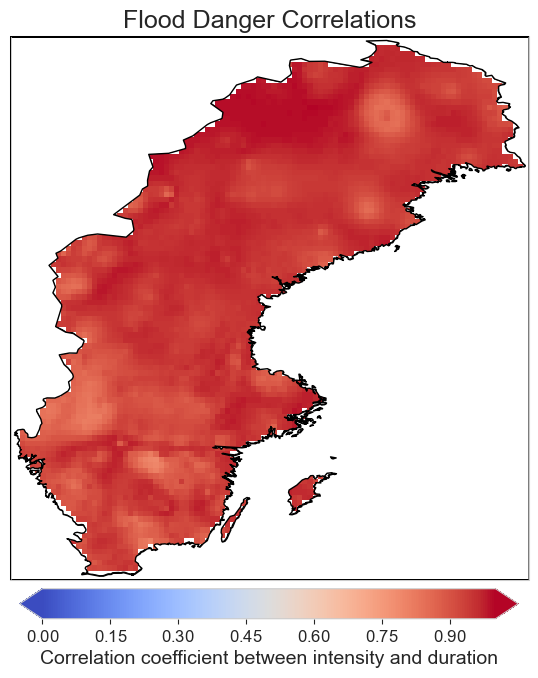

In [79]:
int_dur_cor=calculate_corr(fl_ints_np, fl_durs_np)
plot_map(int_dur_cor, 'Flood Danger Correlations','Correlation coefficient between intensity and duration', 0, 1, 0, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

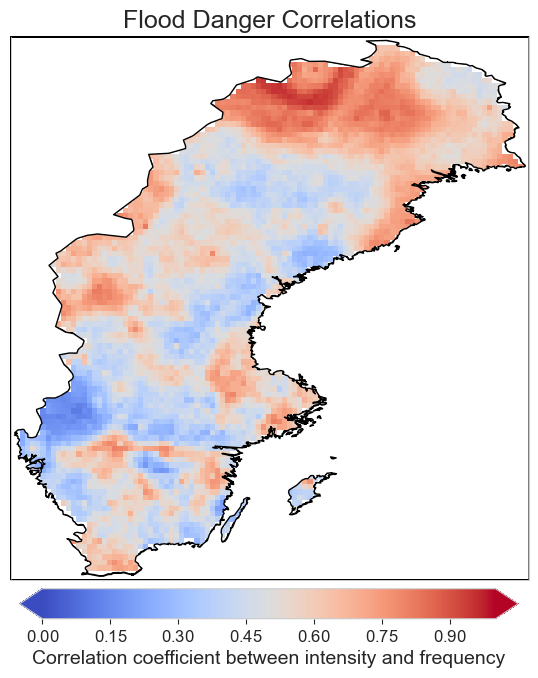

In [78]:
plot_map(int_freq_cor, 'Flood Danger Correlations','Correlation coefficient between intensity and frequency', 0, 1, 0, 'imshow', 'normal','no','no')

In [57]:
import xarray as xr
dfi_ds=xr.open_dataset('Fidx.nc') # Previously calculated Flood Index

In [45]:
fl_ds_yearly

<xarray.Dataset>
Dimensions:  (time: 101, lat: 100, lon: 100)
Coordinates:
  * lat      (lat) float64 55.34 55.48 55.62 55.76 ... 68.76 68.9 69.04 69.18
  * lon      (lon) float64 11.0 11.13 11.26 11.4 ... 23.72 23.85 23.98 24.11
  * time     (time) datetime64[ns] 1921-12-31 1922-12-31 ... 2021-12-31
Data variables:
    fl_durs  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fl_ints  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fl_days  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fl_freq  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

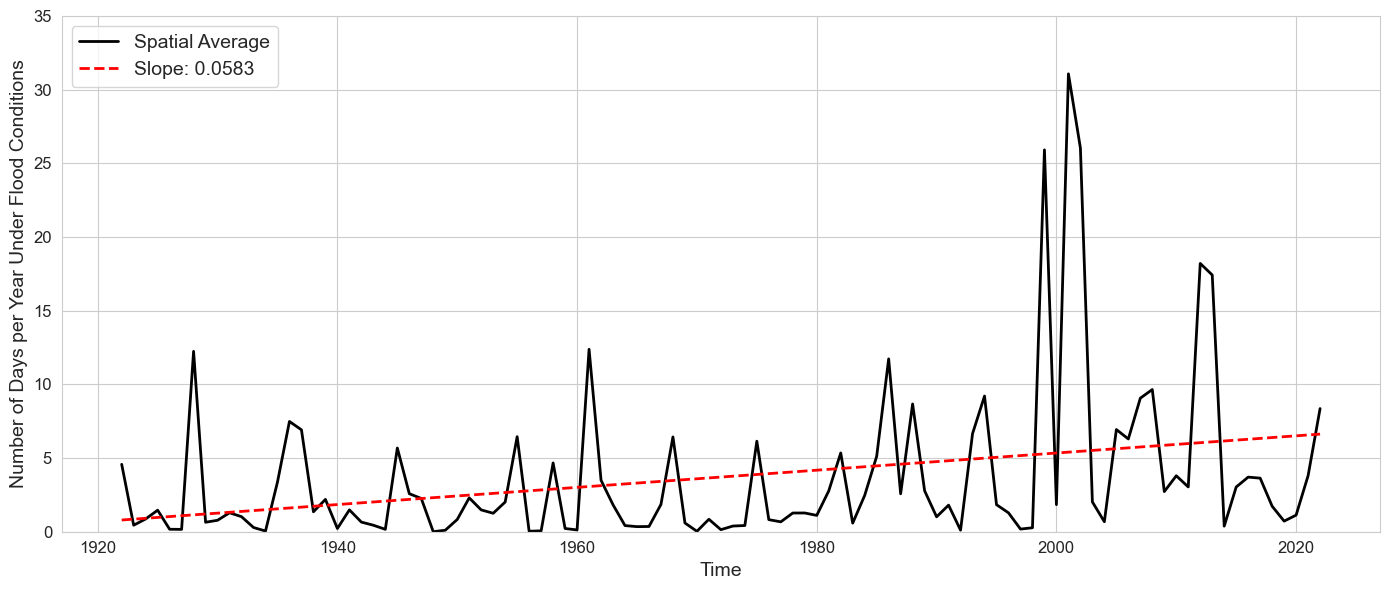

Average from 1922-1971: 2.14
Average from 1972-2021: 5.35
Projected Average from 2022-2071: 8.11


In [80]:
# Plot national average number of days under flood conditions 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import xarray as xr
# Plot Daily Flood Index
# convert dataset to dataframe
fday_df = fl_ds_yearly.to_dataframe().reset_index()
# plot the data
plt.figure(figsize=(14,6))
sns.set_style('whitegrid')
for lat, lon in zip(fday_df['lat'].unique(), fday_df['lon'].unique()):
    fday_df_subset = fday_df[(fday_df['lat'] == lat) & (fday_df['lon'] == lon)]
    x = fday_df_subset['time']
    y = fday_df_subset['fl_days']
    #plt.plot(x, y, color='lightgray', alpha=0.1, linewidth=0.5)    
avg_fday_df = fday_df.groupby('time').mean().reset_index()
slope, intercept, r_value, p_value, std_err = linregress(avg_fday_df.index.values, avg_fday_df['fl_days'])
trend_line = slope * avg_fday_df.index.values + intercept
plt.plot(avg_fday_df['time'], avg_fday_df['fl_days'], color='black', linewidth=2, label='Spatial Average')
plt.plot(avg_fday_df['time'], trend_line, color='red', linestyle='--', linewidth=2, label='Slope: '+str(round(slope,4)))
plt.ylim([0, 35])

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of Days per Year Under Flood Conditions', fontsize=14)
#plt.title('SPEI12 Timeseries', fontsize=14)
# Set the font size for tick labels
plt.tick_params(axis='both', labelsize=12)
#plt.legend(loc='upper center', ncol=10)
plt.legend(fontsize=14, loc='upper left')
plt.tight_layout()
plt.savefig('fdays.svg')
plt.show()
obs1_avg=round(np.nanmean(avg_fday_df['fl_days'].iloc[0:50]), 2)
obs2_avg=round(np.nanmean(avg_fday_df['fl_days'].iloc[51:101]), 2)
proj_avg=round(np.nanmean(slope * (avg_fday_df.index.values[0:50]+101) +intercept), 2)
print(f"Average from 1922-1971: {obs1_avg}")
print(f"Average from 1972-2021: {obs2_avg}")
print(f"Projected Average from 2022-2071: {proj_avg}")

In [140]:
# Mask out values outside country boundaries
lat_grid = np.linspace(55.3376, 69.1763, 100) 
lon_grid = np.linspace(11, 24.113, 100)
from shapely.geometry import Polygon, Point
from cartopy.io import shapereader
import geopandas
def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]
# Mask from natural earth (more below)
# request data for use by geopandas
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

# get geometry and polygon of a country
poly = [df.loc[df['ADMIN'] == 'Sweden']['geometry'].values[0]]
exts = [min(lon_grid)-1, max(lon_grid)+1, min(lat_grid)-1, max(lat_grid)+1]
msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
# create boolean mask where True=inside polygon
mask=np.zeros((len(lat_grid),len(lon_grid)),dtype=bool)
for i, y in enumerate(lat_grid):
    for j, x in enumerate(lon_grid):
        mask[i,j]=Point(x,y).within(msk)